In [56]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv("inputdf.csv")
df = df.drop(['Unnamed: 0'], axis =1)

In [3]:
df['user_id'] = np.random.randint(1,5, size=len(df))

In [4]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,job_state,job_simp,Python,R,Spark,AWS,Excel,SQL,age,user_id
0,Data Scientist,$80K-$120K (Employer est.),About ClearCut Analytics\nClearCut was founded...,4.8,ClearCut Analytics\n4.8,"Chicago, IL",1 to 50 Employees,2016,Company - Private,Research & Development,...,IL,data scientist,1,0,0,0,0,1,4,2
1,Data Scientist 1,$80K-$120K (Employer est.),"At NGL, we strive to make data-driven decision...",3.0,National Guardian Life Insurance Company\n3.0,"Madison, WI",201 to 500 Employees,1909,Company - Private,Insurance Carriers,...,WI,data scientist,0,0,0,0,1,0,111,2
2,Data Scientist,$80K-$120K (Employer est.),Job Description:Metron is seeking talented Dat...,3.0,"Metron, Inc.\n3.0","Reston, VA",51 to 200 Employees,-1,Company - Private,Electrical & Electronic Manufacturing,...,VA,data scientist,1,0,0,0,1,1,-1,3
3,Certified Lab Scientist or Certified Lab Tech,$80K-$120K (Employer est.),Prairie Ridge Health is looking for a team mem...,-1.0,Prairie Ridge Health,"Columbus, WI",201 to 500 Employees,-1,Hospital,Unknown,...,WI,miscellaneous,0,0,0,0,0,0,-1,1
4,Senior Data Scientist,$80K-$120K (Employer est.),"Sartorius Stedim Data Analytics, a market lead...",3.6,Sartorius\n3.6,"Albuquerque, NM",5001 to 10000 Employees,1870,Company - Public,Biotech & Pharmaceuticals,...,NM,data scientist,1,0,0,0,1,0,150,4


In [5]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [6]:
df1=MultiColumnLabelEncoder(columns = ['job_state','job_simp','Sector','Revenue','Size','Industry','Type of ownership']).fit_transform(df)

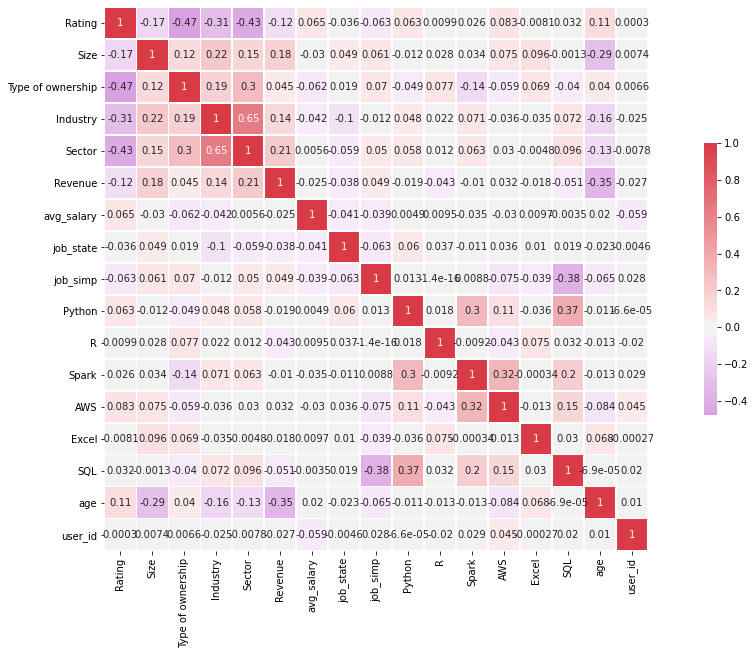

In [57]:
plt.rcParams['figure.figsize'] = [20, 10]
cmap = sns.diverging_palette(300, 10, as_cmap=True)
sns.heatmap(df1[['Rating','Size','Type of ownership','Industry','Sector','Revenue','avg_salary','job_state','job_simp','Python','R','Spark','AWS','Excel','SQL','age','user_id']].corr(),vmax=1, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

## Train Test Split

In [9]:
#declare input and output dfs
inputdf = df1[['Rating','Size','Type of ownership','Industry','Sector','Revenue','avg_salary','job_state','job_simp','Python','R','Spark','AWS','Excel','SQL','age']]
outputdf = df1.loc[:,'user_id']

#split train and test datasets to 80:20 % ratio
train_size = int(len(inputdf.index) * 0.8)
print(len(outputdf))
print(train_size)
X_train, X_test = inputdf.loc[0:train_size, :], inputdf.loc[train_size: len(inputdf.index), :]
Y_train, Y_test = outputdf[0:train_size+1], outputdf.loc[train_size: len(outputdf.index)]

#Count verifications
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('Y Training Observations: %d' % (len(Y_train)))
print('Y Testing Observations: %d' % (len(Y_test)))

1000
800
X Training Observations: 801
X Testing Observations: 200
Y Training Observations: 801
Y Testing Observations: 200


## Initial ML Classification

In [10]:
#running all models and comparing accuracies
models = []
models.append(('LogisticRegression' , LogisticRegression()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NaiveBayes' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RandomForest' , RandomForestClassifier(n_estimators=50)))

for name, model in models:
    clf = model
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    accu_score = accuracy_score(Y_test, Y_pred)
    print(name + ": " + str(accu_score))

LogisticRegression: 0.24
KNN: 0.24
CART: 0.22
NaiveBayes: 0.26
SVM: 0.215
RandomForest: 0.23


## Scaled ML Classification

In [11]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
rescaledValidationX = scaler.transform(X_test)

In [12]:
models = []
models.append(('LogisticRegression' , LogisticRegression()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NaiveBayes' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RandomForest' , RandomForestClassifier(n_estimators=50)))

for name, model in models:
    clf = model
    clf.fit(rescaledX, Y_train)
    Y_pred = clf.predict(rescaledValidationX)
    accu_score = accuracy_score(Y_test, Y_pred)
    print(name + ": " + str(accu_score))

LogisticRegression: 0.25
KNN: 0.215
CART: 0.22
NaiveBayes: 0.26
SVM: 0.25
RandomForest: 0.24


In [24]:
model_cart = GaussianNB()
model_cart.fit(X_train, Y_train)
predictions = model_cart.predict(X_test)

print("classification report: ")
print(classification_report(Y_test, predictions))


classification report: 
              precision    recall  f1-score   support

           1       0.21      0.05      0.09        55
           2       0.22      0.28      0.25        46
           3       0.29      0.58      0.38        48
           4       0.27      0.16      0.20        51

    accuracy                           0.26       200
   macro avg       0.25      0.27      0.23       200
weighted avg       0.25      0.26      0.22       200



## Class Imbalance ML Classification

In [34]:
from imblearn.over_sampling import SMOTE
# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 1
sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
X_res, y_res = sm.fit_resample(inputdf, outputdf)

In [38]:
#running all models and comparing accuracies
models = []
models.append(('LogisticRegression' , LogisticRegression()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NaiveBayes' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RandomForest' , RandomForestClassifier(n_estimators=50)))

for name, model in models:
    clf = model
    clf.fit(X_res, y_res)
    Y_pred = clf.predict(X_test)
    accu_score = accuracy_score(Y_test, Y_pred)
    print(name + ": " + str(accu_score))

LogisticRegression: 0.3
KNN: 0.45
CART: 0.735
NaiveBayes: 0.305
SVM: 0.275
RandomForest: 0.735


In [39]:
#best model fit
model=RandomForestClassifier(n_estimators=50)
model.fit(X_res, y_res)
Y_pred = model.predict(X_test)
prediction_df = df.iloc[:200]
prediction_df['predictions'] = Y_pred

In [41]:
#model evaluation
print("classification report: ")
print(classification_report(Y_test, Y_pred))

classification report: 
              precision    recall  f1-score   support

           1       0.77      0.73      0.75        55
           2       0.76      0.74      0.75        46
           3       0.70      0.81      0.75        48
           4       0.72      0.67      0.69        51

    accuracy                           0.73       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.74      0.73      0.73       200



## Hyperparamater Optimization

In [44]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_res, y_res)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  2.4min finished


In [55]:
bestF.best_params_

{'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [50]:
#evaluation of hyperparameter optimized model
Y_pred1 = bestF.predict(X_test)
print("classification report: ")
print(classification_report(Y_test, Y_pred1))

classification report: 
              precision    recall  f1-score   support

           1       0.75      0.75      0.75        55
           2       0.86      0.70      0.77        46
           3       0.70      0.77      0.73        48
           4       0.67      0.73      0.70        51

    accuracy                           0.73       200
   macro avg       0.75      0.73      0.74       200
weighted avg       0.74      0.73      0.74       200



In [51]:
#predictions
prediction_df = df.iloc[:200]
prediction_df['predictions'] = Y_pred1
prediction_df

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,job_simp,Python,R,Spark,AWS,Excel,SQL,age,user_id,predictions
0,Data Scientist,$80K-$120K (Employer est.),About ClearCut Analytics\nClearCut was founded...,4.8,ClearCut Analytics\n4.8,"Chicago, IL",1 to 50 Employees,2016,Company - Private,Research & Development,...,data scientist,1,0,0,0,0,1,4,2,1
1,Data Scientist 1,$80K-$120K (Employer est.),"At NGL, we strive to make data-driven decision...",3.0,National Guardian Life Insurance Company\n3.0,"Madison, WI",201 to 500 Employees,1909,Company - Private,Insurance Carriers,...,data scientist,0,0,0,0,1,0,111,2,1
2,Data Scientist,$80K-$120K (Employer est.),Job Description:Metron is seeking talented Dat...,3.0,"Metron, Inc.\n3.0","Reston, VA",51 to 200 Employees,-1,Company - Private,Electrical & Electronic Manufacturing,...,data scientist,1,0,0,0,1,1,-1,3,3
3,Certified Lab Scientist or Certified Lab Tech,$80K-$120K (Employer est.),Prairie Ridge Health is looking for a team mem...,-1.0,Prairie Ridge Health,"Columbus, WI",201 to 500 Employees,-1,Hospital,Unknown,...,miscellaneous,0,0,0,0,0,0,-1,1,2
4,Senior Data Scientist,$80K-$120K (Employer est.),"Sartorius Stedim Data Analytics, a market lead...",3.6,Sartorius\n3.6,"Albuquerque, NM",5001 to 10000 Employees,1870,Company - Public,Biotech & Pharmaceuticals,...,data scientist,1,0,0,0,1,0,150,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Senior Machine Learning Engineer,$60K-$97K (Glassdoor est.),"SkySync is a dynamic, fast-paced, venture-back...",5.0,SkySync\n5.0,"Ann Arbor, MI",51 to 200 Employees,2011,Company - Private,Computer Hardware & Software,...,mle,1,0,0,1,1,0,9,3,1
196,Data Engineer,$60K-$97K (Glassdoor est.),"Job Description\n\nWhy consider OPI, and why d...",4.8,Object Partners\n4.8,"Des Moines, IA",201 to 500 Employees,1996,Company - Private,Consulting,...,data engineer,0,0,1,1,0,1,24,4,4
197,Data Scientist,$60K-$97K (Glassdoor est.),"Join Tubi, a premium streaming service leading...",4.3,Tubi\n4.3,"San Francisco, CA",51 to 200 Employees,2014,Company - Private,Internet,...,data scientist,1,0,1,0,0,1,6,3,1
198,Senior Data Analyst,$60K-$97K (Glassdoor est.),About Life 360\n\n\nLife360 brings families cl...,3.6,Life360\n3.6,"Remote, REM",51 to 200 Employees,2008,Company - Public,Internet,...,analyst,1,0,0,0,0,1,12,1,4


## recommendation function

In [52]:
def recommend(userid):
    rslt_df = prediction_df[(prediction_df['predictions'] == userid)]
    return rslt_df.iloc[:,:7]

In [62]:
recommend(1)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size
0,Data Scientist,$80K-$120K (Employer est.),About ClearCut Analytics\nClearCut was founded...,4.8,ClearCut Analytics\n4.8,"Chicago, IL",1 to 50 Employees
1,Data Scientist 1,$80K-$120K (Employer est.),"At NGL, we strive to make data-driven decision...",3.0,National Guardian Life Insurance Company\n3.0,"Madison, WI",201 to 500 Employees
8,"Principal Scientist, Analytical Development",$80K-$120K (Employer est.),"About Allogene Therapeutics, Inc:Allogene Ther...",5.0,Allogene Therapeutics\n5.0,"South San Francisco, CA",51 to 200 Employees
9,Data Science Engineer Full Stack - AI,$80K-$120K (Employer est.),Data Science Engineer Full Stack - AI\n\nOverv...,2.8,BryterCX\n2.8,"United States, USA",51 to 200 Employees
10,Data Scientist,$80K-$120K (Employer est.),Job Title: Data Scientists\n\nJob Description\...,2.2,Great-Circle Technologies\n2.2,"Chantilly, VA",1 to 50 Employees
14,Data Scientist,$80K-$120K (Employer est.),"At Varen, our performance is measured by the s...",4.2,Varen Technologies\n4.2,"McLean, VA",51 to 200 Employees
15,Data Scientist,$80K-$120K (Employer est.),Data Scientist\n\nLanguage: English\n\nLocatio...,3.6,Buckman\n3.6,"Memphis, TN",1001 to 5000 Employees
16,Data Scientist,$80K-$120K (Employer est.),Join our team dedicated to developing and exec...,4.5,Novetta\n4.5,"Annapolis Junction, MD",501 to 1000 Employees
17,Data Scientist,$80K-$120K (Employer est.),POSITION SUMMARY:\n\nThe Data Scientist is a h...,4.0,Berg Health\n4.0,"Framingham, MA",51 to 200 Employees
23,Staff Data Scientist,$80K-$120K (Employer est.),"At Plenty, we're on a mission to give people i...",4.5,Plenty\n4.5,"South San Francisco, CA",201 to 500 Employees
